In [1]:
import datatable as dt
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

import lightgbm as lgb
from fastprogress import progress_bar
from collections import defaultdict
from sklearn.model_selection import GroupKFold

#import riiideducation

In [2]:
data_path = '../input/riiid-test-answer-prediction/train.csv'
questions_path = '../input/riiid-test-answer-prediction/questions.csv'
data_types_dict = {
    'user_id': 'int32',
    'content_id': 'int16',
    'answered_correctly': 'int8',
    'prior_question_elapsed_time': 'float32',
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

In [3]:
train_df = dt.fread(data_path, columns=set(data_types_dict.keys())).to_pandas()
questions_df = pd.read_csv(
    questions_path,
    usecols=[0, 3],
    dtype={'question_id': 'int16', 'part': 'int8'}
)

In [4]:
def add_features(df, 
                 answered_correctly_u_count, 
                 answered_correctly_u_sum, 
                 elapsed_time_u_sum, 
                 explanation_u_sum, 
                 timestamp_u, 
                 timestamp_u_incorrect, 
                 answered_correctly_q_count, 
                 answered_correctly_q_sum, 
                 elapsed_time_q_sum, 
                 explanation_q_sum, 
                 answered_correctly_uq, 
                 update=True):
    # -----------------------------------------------------------------------
    # Client features
    answered_correctly_u_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_u_avg = np.zeros(len(df), dtype = np.float32)
    explanation_u_avg = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_1 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_2 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_recency_3 = np.zeros(len(df), dtype = np.float32)
    timestamp_u_incorrect_recency = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # Question features
    answered_correctly_q_avg = np.zeros(len(df), dtype = np.float32)
    elapsed_time_q_avg = np.zeros(len(df), dtype = np.float32)
    explanation_q_avg = np.zeros(len(df), dtype = np.float32)
    # -----------------------------------------------------------------------
    # User Question
    answered_correctly_uq_count = np.zeros(len(df), dtype = np.int32)
    # -----------------------------------------------------------------------
    
    for num, row in enumerate(df[['user_id', 'answered_correctly', 'content_id', 'prior_question_elapsed_time', 'prior_question_had_explanation', 'timestamp']].values):
        
        # Client features assignation
        # ------------------------------------------------------------------
        if answered_correctly_u_count[row[0]] != 0:
            answered_correctly_u_avg[num] = answered_correctly_u_sum[row[0]] / answered_correctly_u_count[row[0]]
            elapsed_time_u_avg[num] = elapsed_time_u_sum[row[0]] / answered_correctly_u_count[row[0]]
            explanation_u_avg[num] = explanation_u_sum[row[0]] / answered_correctly_u_count[row[0]]
        else:
            answered_correctly_u_avg[num] = np.nan
            elapsed_time_u_avg[num] = np.nan
            explanation_u_avg[num] = np.nan
            
        if len(timestamp_u[row[0]]) == 0:
            timestamp_u_recency_1[num] = np.nan
            timestamp_u_recency_2[num] = np.nan
            timestamp_u_recency_3[num] = np.nan
        elif len(timestamp_u[row[0]]) == 1:
            timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][0]
            timestamp_u_recency_2[num] = np.nan
            timestamp_u_recency_3[num] = np.nan
        elif len(timestamp_u[row[0]]) == 2:
            timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][1]
            timestamp_u_recency_2[num] = row[5] - timestamp_u[row[0]][0]
            timestamp_u_recency_3[num] = np.nan
        elif len(timestamp_u[row[0]]) == 3:
            timestamp_u_recency_1[num] = row[5] - timestamp_u[row[0]][2]
            timestamp_u_recency_2[num] = row[5] - timestamp_u[row[0]][1]
            timestamp_u_recency_3[num] = row[5] - timestamp_u[row[0]][0]
        
        if len(timestamp_u_incorrect[row[0]]) == 0:
            timestamp_u_incorrect_recency[num] = np.nan
        else:
            timestamp_u_incorrect_recency[num] = row[5] - timestamp_u_incorrect[row[0]][0]
            
        # ------------------------------------------------------------------
        # Question features assignation
        if answered_correctly_q_count[row[2]] != 0:
            answered_correctly_q_avg[num] = answered_correctly_q_sum[row[2]] / answered_correctly_q_count[row[2]]
            elapsed_time_q_avg[num] = elapsed_time_q_sum[row[2]] / answered_correctly_q_count[row[2]]
            explanation_q_avg[num] = explanation_q_sum[row[2]] / answered_correctly_q_count[row[2]]
        else:
            answered_correctly_q_avg[num] = np.nan
            elapsed_time_q_avg[num] = np.nan
            explanation_q_avg[num] = np.nan
        # ------------------------------------------------------------------
        # Client Question assignation
        answered_correctly_uq_count[num] = answered_correctly_uq[row[0]][row[2]]
        # ------------------------------------------------------------------
        # ------------------------------------------------------------------
        # Client features updates
        answered_correctly_u_count[row[0]] += 1
        elapsed_time_u_sum[row[0]] += row[3]
        explanation_u_sum[row[0]] += int(row[4])
        if len(timestamp_u[row[0]]) == 3:
            timestamp_u[row[0]].pop(0)
            timestamp_u[row[0]].append(row[5])
        else:
            timestamp_u[row[0]].append(row[5])
        # ------------------------------------------------------------------
        # Question features updates
        answered_correctly_q_count[row[2]] += 1
        elapsed_time_q_sum[row[2]] += row[3]
        explanation_q_sum[row[2]] += int(row[4])
        # ------------------------------------------------------------------
        # Client Question updates
        answered_correctly_uq[row[0]][row[2]] += 1
        # ------------------------------------------------------------------
        # Flag for train_dfing and inference
        if update:
            # ------------------------------------------------------------------
            # Client features updates
            answered_correctly_u_sum[row[0]] += row[1]
            if row[1] == 0:
                if len(timestamp_u_incorrect[row[0]]) == 1:
                    timestamp_u_incorrect[row[0]].pop(0)
                    timestamp_u_incorrect[row[0]].append(row[5])
                else:
                    timestamp_u_incorrect[row[0]].append(row[5])
            
            # ------------------------------------------------------------------
            # Question features updates
            answered_correctly_q_sum[row[2]] += row[1]
            # ------------------------------------------------------------------
             
            
    user_df = pd.DataFrame({'answered_correctly_u_avg': answered_correctly_u_avg, 'elapsed_time_u_avg': elapsed_time_u_avg, 'explanation_u_avg': explanation_u_avg, 
                            'answered_correctly_q_avg': answered_correctly_q_avg, 'elapsed_time_q_avg': elapsed_time_q_avg, 'explanation_q_avg': explanation_q_avg, 
                            'answered_correctly_uq_count': answered_correctly_uq_count, 'timestamp_u_recency_1': timestamp_u_recency_1, 'timestamp_u_recency_2': timestamp_u_recency_2,
                            'timestamp_u_recency_3': timestamp_u_recency_3, 'timestamp_u_incorrect_recency': timestamp_u_incorrect_recency})
    
    df = pd.concat([df, user_df], axis = 1)
    return df
        
def update_features(df, 
                    answered_correctly_u_sum, 
                    answered_correctly_q_sum, 
                    timestamp_u_incorrect):
    for row in df[['user_id', 'answered_correctly', 'content_id', 'content_type_id', 'timestamp']].values:
        if row[3] == 0:
            # ------------------------------------------------------------------
            # Client features updates
            answered_correctly_u_sum[row[0]] += row[1]
            if row[1] == 0:
                if len(timestamp_u_incorrect[row[0]]) == 1:
                    timestamp_u_incorrect[row[0]].pop(0)
                    timestamp_u_incorrect[row[0]].append(row[4])
                else:
                    timestamp_u_incorrect[row[0]].append(row[4])
            # ------------------------------------------------------------------
            # Question features updates
            answered_correctly_q_sum[row[2]] += row[1]
            # ------------------------------------------------------------------
            
    return

def read_and_preprocess(feature_engineering=False):
    
    data_path = '../input/riiid-test-answer-prediction/train.csv'
    question_file = '../input/riiid-test-answer-prediction/questions.csv'
    
    # Read data
    feld_needed = ['timestamp', 
                   'user_id', 
                   'answered_correctly', 
                   'content_id', 
                   'content_type_id', 
                   'prior_question_elapsed_time', 
                   'prior_question_had_explanation']
    train_df = train_df_df = dt.fread(data_path).to_pandas()[feld_needed]
    #train_df = train_df.groupby('user_id').tail(1000).reset_index(drop=True)
    # Delete some trianing data to don't have ram problems
    #if feature_engineering:
    #    train_df = train_df.iloc[-40000000:]
    
    # Filter by content_type_id to discard lectures
    train_df = train_df.loc[train_df.content_type_id == False].reset_index(drop=True)
    
    # Changing dtype to avoid lightgbm error
    train_df['prior_question_had_explanation'] = train_df.prior_question_had_explanation.fillna(False).astype('int8')
    
    # Fill prior question elapsed time with the mean
    prior_question_elapsed_time_mean = train_df['prior_question_elapsed_time'].dropna().mean()
    train_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace = True)
    
    # Merge with question dataframe
    questions_df = pd.read_csv(question_file)
    questions_df['part'] = questions_df['part'].astype(np.int32)
    questions_df['bundle_id'] = questions_df['bundle_id'].astype(np.int32)
    
    train_df = pd.merge(train_df, 
                     questions_df[['question_id', 'part']], 
                     left_on='content_id', 
                     right_on='question_id', 
                     how='left')
    
    # Client dictionaries
    answered_correctly_u_count = defaultdict(int)
    answered_correctly_u_sum = defaultdict(int)
    elapsed_time_u_sum = defaultdict(int)
    explanation_u_sum = defaultdict(int)
    timestamp_u = defaultdict(list)
    timestamp_u_incorrect = defaultdict(list)
    
    # Question dictionaries
    answered_correctly_q_count = defaultdict(int)
    answered_correctly_q_sum = defaultdict(int)
    elapsed_time_q_sum = defaultdict(int)
    explanation_q_sum = defaultdict(int)
    
    # Client Question dictionary
    answered_correctly_uq = defaultdict(lambda: defaultdict(int))
    
    print('User feature calculation started...')
    print('\n')
    train_df = add_features(train_df, 
                         answered_correctly_u_count, 
                         answered_correctly_u_sum, 
                         elapsed_time_u_sum, 
                         explanation_u_sum, 
                         timestamp_u, 
                         timestamp_u_incorrect, 
                         answered_correctly_q_count, 
                         answered_correctly_q_sum, 
                         elapsed_time_q_sum, 
                         explanation_q_sum, 
                         answered_correctly_uq)
    gc.collect()
    print('User feature calculation completed...')
    print('\n')
    
    features_dicts = {
        'answered_correctly_u_count': answered_correctly_u_count,
        'answered_correctly_u_sum': answered_correctly_u_sum,
        'elapsed_time_u_sum': elapsed_time_u_sum,
        'explanation_u_sum': explanation_u_sum,
        'answered_correctly_q_count': answered_correctly_q_count,
        'answered_correctly_q_sum': answered_correctly_q_sum,
        'elapsed_time_q_sum': elapsed_time_q_sum,
        'explanation_q_sum': explanation_q_sum,
        'answered_correctly_uq': answered_correctly_uq,
        'timestamp_u': timestamp_u,
        'timestamp_u_incorrect': timestamp_u_incorrect,
        'content_id': train_df.content_id,
    }
    
    return (train_df, 
            questions_df, 
            prior_question_elapsed_time_mean, 
            features_dicts)

In [5]:
(train_df, questions_df, prior_question_elapsed_time_mean, features_dicts) = read_and_preprocess(True)

User feature calculation started...


User feature calculation completed...




In [6]:
target = 'answered_correctly'
train_df

,timestamp,user_id,answered_correctly,content_id,content_type_id,prior_question_elapsed_time,prior_question_had_explanation,question_id,part,answered_correctly_u_avg,elapsed_time_u_avg,explanation_u_avg,answered_correctly_q_avg,elapsed_time_q_avg,explanation_q_avg,answered_correctly_uq_count,timestamp_u_recency_1,timestamp_u_recency_2,timestamp_u_recency_3,timestamp_u_incorrect_recency
0,0,115,1,5692,False,25423.810043,0,5692,5,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
1,56943,115,1,5716,False,37000.000000,0,5716,5,1.000000,25423.810547,0.000000,NaN,NaN,NaN,0,56943.0,NaN,NaN,NaN
2,118363,115,1,128,False,55000.000000,0,128,1,1.000000,31211.904297,0.000000,NaN,NaN,NaN,0,61420.0,118363.0,NaN,NaN
3,131167,115,1,7860,False,19000.000000,0,7860,1,1.000000,39141.269531,0.000000,NaN,NaN,NaN,0,12804.0,74224.0,131167.0,NaN
4,137965,115,1,7922,False,11000.000000,0,7922,1,1.000000,34105.953125,0.000000,NaN,NaN,NaN,0,6798.0,19602.0,81022.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99271295,428564420,2147482888,1,3586,False,18000.000000,1,3586,5,0.500000,28882.900391,0.636364,0.741004,24782.769531,0.995645,0,21548.0,47107.0,98251.0,114811.0
99271296,428585000,2147482888,1,6341,False,14000.000000,1,6341,5,0.521739,28409.730469,0.652174,0.527742,24833.601562,0.961934,0,20580.0,42128.0,67687.0,135391.0
99271297,428613475,2147482888,1,4212,False,14000.000000,1,4212,5,0.541667,27809.326172,0.666667,0.616190,25971.373047,0.981282,0,28475.0,49055.0,70603.0,163866.0
99271298,428649406,2147482888,0,6343,False,22000.000000,1,6343,5,0.560000,27256.953125,0.680000,0.661798,24750.660156,0.966788,0,35931.0,64406.0,84986.0,199797.0


In [7]:
gkf = GroupKFold(5)
for n, fold_idx in enumerate(gkf.split(train_df, groups=train_df.user_id)):
    print(n, fold_idx)

0 (array([       0,        1,        2, ..., 99271297, 99271298, 99271299]), array([      46,       47,       48, ..., 99271270, 99271271, 99271272]))
1 (array([       0,        1,        2, ..., 99271297, 99271298, 99271299]), array([     611,      612,      613, ..., 99269694, 99269695, 99269696]))
2 (array([      46,       47,       48, ..., 99271297, 99271298, 99271299]), array([       0,        1,        2, ..., 99270945, 99270946, 99270947]))
3 (array([       0,        1,        2, ..., 99271270, 99271271, 99271272]), array([      76,       77,       78, ..., 99271297, 99271298, 99271299]))
4 (array([       0,        1,        2, ..., 99271297, 99271298, 99271299]), array([    8630,     8631,     8632, ..., 99270193, 99270194, 99270195]))


In [8]:
features = [
    'prior_question_elapsed_time',
    'prior_question_had_explanation',
    'part',
    'answered_correctly_u_avg',
    'elapsed_time_u_avg',
    'explanation_u_avg',
    'answered_correctly_q_avg',
    'elapsed_time_q_avg',
    'explanation_q_avg',
    'answered_correctly_uq_count',
    'timestamp_u_recency_1',
    'timestamp_u_recency_2',
    'timestamp_u_recency_3',
    'timestamp_u_incorrect_recency',
    
    'content_id',
]

trn_idx, val_idx = fold_idx

trn_data = (train_df.loc[trn_idx][features], train_df.loc[trn_idx][target])
val_data = (train_df.loc[val_idx][features], train_df.loc[val_idx][target])

# 1.

In [9]:
# 2.
params = {
    'objective': 'binary',
    'num_rounds': 1000,
    'seed': 42,
    'metric': 'auc',
    'learning_rate': 0.1,
    'force_row_wise': True,
    
    'max_depth': -1,
    'num_leaves': 1000,
    
    'min_child_samples': 100,
      
}

        
model = lgb.LGBMClassifier(**params)
model.fit(
    *trn_data,
    eval_set=[trn_data, val_data], 
    verbose=50,
    early_stopping_rounds=50,
)

C:\Users\utl\anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1000, num_rounds=1000 will be ignored. Current value: num_iterations=1000
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.774107	valid_1's auc: 0.773585
[100]	training's auc: 0.777561	valid_1's auc: 0.776492
[150]	training's auc: 0.778983	valid_1's auc: 0.777375
[200]	training's auc: 0.779769	valid_1's auc: 0.777697
[250]	training's auc: 0.780501	valid_1's auc: 0.777936
[300]	training's auc: 0.781167	valid_1's auc: 0.778113
[350]	training's auc: 0.781823	valid_1's auc: 0.778266
[400]	training's auc: 0.78243	valid_1's auc: 0.778373
[450]	training's auc: 0.782951	valid_1's auc: 0.778434
[500]	training's auc: 0.783498	valid_1's auc: 0.778502
[550]	training's auc: 0.784016	valid_1's auc: 0.778574
[600]	training's auc: 0.78457	valid_1's auc: 0.778653
[650]	training's auc: 0.785096	valid_1's auc: 0.778707
[700]	training's auc: 0.785525	valid_1's auc: 0.778725
[750]	training's auc: 0.786002	valid_1's auc: 0.778763


LGBMClassifier(force_row_wise=True, metric='auc', min_child_samples=100,
               num_leaves=1000, num_rounds=1000, objective='binary', seed=42)

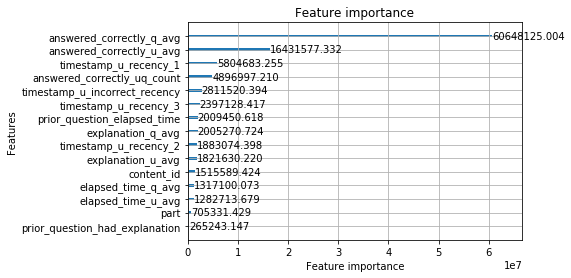

In [10]:
lgb.plot_importance(model, importance_type='gain')

In [12]:
import pickle
save_path = f'lgb_fold{n}.pickle'
pickle.dump(model, open(save_path, 'wb'))

In [13]:
save_path = f'lgb_fold{n}.pickle'
with open(save_path, 'wb') as f:
    pickle.dump(model, f)

In [15]:
with open(save_path, 'rb') as f:
    a = pickle.load(f)

In [ ]:
#a = lgb.Booster(model_file=save_path)

In [ ]:
#a.predict(train_df.loc[val_idx][features])

In [ ]:
#model.predict(train_df.loc[val_idx][features])

# inference

In [17]:
def inference(TARGET, FEATURES, model, questions_df, prior_question_elapsed_time_mean, features_dicts):
    
    # Get feature dict
    answered_correctly_u_count = features_dicts['answered_correctly_u_count']
    answered_correctly_u_sum = features_dicts['answered_correctly_u_sum']
    elapsed_time_u_sum = features_dicts['elapsed_time_u_sum']
    explanation_u_sum = features_dicts['explanation_u_sum']
    answered_correctly_q_count = features_dicts['answered_correctly_q_count']
    answered_correctly_q_sum = features_dicts['answered_correctly_q_sum']
    elapsed_time_q_sum = features_dicts['elapsed_time_q_sum']
    explanation_q_sum = features_dicts['explanation_q_sum']
    answered_correctly_uq = features_dicts['answered_correctly_uq']
    timestamp_u = features_dicts['timestamp_u']
    timestamp_u_incorrect = features_dicts['timestamp_u_incorrect']
    
    # Get api iterator and predictor
    env = riiideducation.make_env()
    iter_test = env.iter_test()
    set_predict = env.predict
    
    previous_test_df = None
    for (test_df, sample_prediction_df) in iter_test:
        if previous_test_df is not None:
            previous_test_df[TARGET] = eval(test_df["prior_group_answers_correct"].iloc[0])
            update_features(previous_test_df, answered_correctly_u_sum, answered_correctly_q_sum, timestamp_u_incorrect)
        previous_test_df = test_df.copy()
        test_df = test_df[test_df['content_type_id'] == 0].reset_index(drop = True)
        test_df['prior_question_had_explanation'] = test_df.prior_question_had_explanation.fillna(False).astype('int8')
        test_df['prior_question_elapsed_time'].fillna(prior_question_elapsed_time_mean, inplace = True)
        test_df = pd.merge(test_df, questions_df[['question_id', 'part']], left_on = 'content_id', right_on = 'question_id', how = 'left')
        test_df[TARGET] = 0
        test_df = add_features(test_df, answered_correctly_u_count, answered_correctly_u_sum, elapsed_time_u_sum, explanation_u_sum, timestamp_u, timestamp_u_incorrect, answered_correctly_q_count, answered_correctly_q_sum, elapsed_time_q_sum, explanation_q_sum, answered_correctly_uq, update = False)
        test_df[TARGET] =  model.predict(test_df[FEATURES])
        set_predict(test_df[['row_id', TARGET]])
        
    print('Job Done')

In [ ]:
inference